# Capstone Project: Select a location for a Real Estate Project

## Introduction

A Chinese group of investors has recently expressed a will to build a five-star hotel with all amenities, including a restaurant, a swimming pool, a gym, a mini shopping mall, and a nightclub in the capital city of Cote d'Ivoire, West Africa. They even planned to introduce a small health care center that should deliver essential medical treatments.  
   
   To maximize their profits, they want to pinpoint the best location in the hotel. Having heard about the professionalism of "DataUnis," a data science company located in Abidjan, they trusted them to handle the project.
   
   As a junior data science in "DataUnis," I was asked to lead a team for this study and come up with a report to solve the problem of these Chinese investors. 


## Background

Abidjan is the capital city of Côte d'Ivoire in West Africa. It is located on the southern Atlantic coast of the country. The country has recently been one of the fastest-growing economies in Africa since 2012, with GDP growth of 8% on average (World Bank). 
 
 The nation is best known internationally by the performance of its football team over the last decade, one of whom “Didier Drogba” the former Chelsea Fc striker is the most famous.
  Despite such an economic growth, a lot of structural and social issues are yet to be tackled. Among them, accommodation issues are one of them. In other words, the relative climate of social peace, the progress the country has recently experienced give considerable opportunities to invest in real estate in the country and especially in Abidjan, which is the major urban center.
  
  When the decision is made to invest in the real estate, the obstacle that comes next is to pinpoint the location, here is where data science and data scientist step in. 
  In this mini-project, geographical data are leveraged to handle a location problem in a real estate project, which is to find the best location to build a five-star hotel in the Ivorian capital city.


## Target Audience

Real estate investors or anyone interested to invest in the hotel industry in Abidjan

In [76]:
# import libraries
from bs4 import BeautifulSoup #use to scrape data online
import requests #use to scrape data online
import pandas as pd # read data into a dataframe format
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
from sklearn.cluster import KMeans # import k-means from clustering stage
import numpy as np
import matplotlib.cm as cm  # Matplotlib and associated plotting modules
import matplotlib.colors as colors
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


### Get the coordinates of Abidjan city

In [3]:
# Grab the coordinates of Abidjan city

user_agent= "Abj_explorer"
address = 'ABIDJAN, ABJ'

geolocator = Nominatim(user_agent=user_agent)
location = geolocator.geocode(address)
latitude_abj = location.latitude
longitude_abj = location.longitude
print('The geograpical coordinates of Abidjan are {}, {}.'.format(latitude_abj, longitude_abj))

The geograpical coordinates of Abidjan are 5.264928299999999, -3.9259475068297522.


## Data import and processing

Little processing was needed since the data were fetched online using the following 
website <https://www.latlong.net> and then organised in an excel spreadsheet

In [6]:
# import the data set

path = r'C:\Users\HP\Desktop\Skillshare\IBM Data Sciences\Capstone\Abidjan GPS Coordinates.xlsx'
df_abj = pd.read_excel(path)
df_abj
    

,Districts,Latitude,Longitude
0,Abobo,5.4329,-4.0389
1,Adjame,5.3651,-4.0236
2,Yopougon,5.3177,-4.0900
3,Plateau,5.3233,-4.0236
4,Attecoube,5.3362,-4.0414
5,Cocody,5.3602,-3.9674
6,Koumassi,5.3030,-3.9419
7,Marcory,5.3027,-3.9827
8,Port-Bouet,5.2773,-3.8859
9,Treichville,5.2921,-4.0134


In [7]:
# drop all the rows with NaN
df_abj.dropna(how='all', axis=0, inplace=True)
df_abj

,Districts,Latitude,Longitude
0,Abobo,5.4329,-4.0389
1,Adjame,5.3651,-4.0236
2,Yopougon,5.3177,-4.0900
3,Plateau,5.3233,-4.0236
4,Attecoube,5.3362,-4.0414
5,Cocody,5.3602,-3.9674
6,Koumassi,5.3030,-3.9419
7,Marcory,5.3027,-3.9827
8,Port-Bouet,5.2773,-3.8859
9,Treichville,5.2921,-4.0134


In [176]:
# create map of Abidjan using latitude and longitude values

map_abj = folium.Map(location=[latitude_abj, longitude_abj], zoom_start=11)

# add markers to map
for lat, lng, Districts in zip(df_abj['Latitude'],df_abj['Longitude'], df_abj['Districts'],):
    label = '{}'.format(Districts)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_abj)  
    

# add pop-up text to each marker on the map
for lat, lng, label in zip(df_abj['Latitude'],df_abj['Longitude'],df_abj['Districts'] ):
    folium.Marker([lat, lng], popup=label).add_to(map_abj)  
    
    
map_abj

#### Next, let us start utilizing the Foursquare API to explore the neighborhoods and segment them

### Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = 'ZKYTNQFGWULGM4TD3CCLWN0MPNQPCMJEBJRT3V3SNPGBJG3Z' # your Foursquare ID
CLIENT_SECRET = 'H2A25N4SNMIJ3XZZ0MCTNLZH1MB1NZ1XSXOUEWWVKBOGEA5L' # your Foursquare Secret
VERSION = '20180604'

print('Your credentials:')
print('CLIENT_ID:' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID:ZKYTNQFGWULGM4TD3CCLWN0MPNQPCMJEBJRT3V3SNPGBJG3Z
CLIENT_SECRET:H2A25N4SNMIJ3XZZ0MCTNLZH1MB1NZ1XSXOUEWWVKBOGEA5L


### Explore all the major venues around in and around the cities within a radius of 6km

In [14]:
LIMIT = 500 
radius = 6000 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=6000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Districts', 
                  'Districts Latitude', 
                  'Districts Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
abj_venues = getNearbyVenues(names=df_abj['Districts'],
                                   latitudes=df_abj['Latitude'],
                                   longitudes=df_abj['Longitude']
                                  )

Abobo
Adjame
Yopougon
Plateau
Attecoube
Cocody
Koumassi
Marcory
Port-Bouet
Treichville
Ile Boulay


In [17]:
abj_venues.shape

(412, 7)

In [19]:
abj_venues.head(10)

,Districts,Districts Latitude,Districts Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abobo,5.4329,-4.0389,Ebimpe,5.451773,-4.073543,Train Station
1,Abobo,5.4329,-4.0389,Zoo,5.382706,-4.022097,Zoo
2,Adjame,5.3651,-4.0236,Norima,5.363668,-3.992067,American Restaurant
3,Adjame,5.3651,-4.0236,le pub,5.375782,-3.998315,Bar
4,Adjame,5.3651,-4.0236,Bao Café,5.348778,-3.996881,Coffee Shop
5,Adjame,5.3651,-4.0236,Des Gateaux & Du Pain,5.360270,-3.989671,Bakery
6,Adjame,5.3651,-4.0236,Casino Mandarine Danga,5.345053,-4.010700,Supermarket
7,Adjame,5.3651,-4.0236,Sofitel Abidjan Hôtel Ivoire,5.327029,-4.004621,Hotel
8,Adjame,5.3651,-4.0236,Hollywood Boulevard,5.375848,-3.990464,Lounge
9,Adjame,5.3651,-4.0236,Nuit De Saigon,5.371588,-3.990445,Vietnamese Restaurant


In [20]:
# check the venue categories available

abj_venues['Venue Category'].unique()

array(['Train Station', 'Zoo', 'American Restaurant', 'Bar',
       'Coffee Shop', 'Bakery', 'Supermarket', 'Hotel', 'Lounge',
       'Vietnamese Restaurant', 'Nightclub', 'African Restaurant',
       'Ice Cream Shop', 'Steakhouse', 'Boutique', 'Fast Food Restaurant',
       'Pizza Place', 'Restaurant', 'Shopping Mall', 'Multiplex',
       'Brewery', 'Plaza', 'BBQ Joint', 'Soccer Field',
       'Italian Restaurant', 'Park', 'Pharmacy', 'Bus Station',
       'Music Venue', 'Soccer Stadium', 'Basketball Stadium', 'Beach Bar',
       'Sandwich Place', 'Bistro', 'Seafood Restaurant', 'Café',
       'Dessert Shop', 'Halal Restaurant', 'Gym',
       'Furniture / Home Store', 'Art Gallery',
       'Middle Eastern Restaurant', 'Harbor / Marina',
       'French Restaurant', 'Cruise', 'Electronics Store', 'Golf Course',
       'Diner', 'Shopping Plaza', 'Neighborhood', 'Grocery Store',
       'Athletics & Sports', 'Gastropub', 'Department Store', 'Tea Room',
       'Frozen Yogurt Shop', 'Resort'

In [21]:
# check the count for each venue category

abj_venues['Venue Category'].value_counts()

Hotel                 43
African Restaurant    25
Shopping Mall         24
Nightclub             20
Restaurant            16
                      ..
Diner                  1
Duty-free Shop         1
Soccer Stadium         1
Neighborhood           1
Shopping Plaza         1
Name: Venue Category, Length: 63, dtype: int64

## Let's focus now on what we are interested in: The hotels in Abidjan

In [24]:
# group the dataframe by Venue category to extract the hotels

df_hot = abj_venues.groupby(['Venue Category']).get_group('Hotel')
df_hot

,Districts,Districts Latitude,Districts Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
7,Adjame,5.3651,-4.0236,Sofitel Abidjan Hôtel Ivoire,5.327029,-4.004621,Hotel
26,Adjame,5.3651,-4.0236,Seen Hotel,5.319175,-4.018727,Hotel
34,Adjame,5.3651,-4.0236,Novotel Hotel Abidjan,5.316030,-4.016349,Hotel
49,Plateau,5.3233,-4.0236,Sofitel Abidjan Hôtel Ivoire,5.327029,-4.004621,Hotel
51,Plateau,5.3233,-4.0236,Seen Hotel,5.319175,-4.018727,Hotel
64,Plateau,5.3233,-4.0236,Novotel Hotel Abidjan,5.316030,-4.016349,Hotel
91,Plateau,5.3233,-4.0236,Azalaï Hotel,5.299542,-3.986272,Hotel
93,Plateau,5.3233,-4.0236,Golf Hotel Abidjan,5.329699,-3.972834,Hotel
103,Attecoube,5.3362,-4.0414,Sofitel Abidjan Hôtel Ivoire,5.327029,-4.004621,Hotel
107,Attecoube,5.3362,-4.0414,Seen Hotel,5.319175,-4.018727,Hotel


In [25]:
# check the shape of the resulting dataframe
df_hot.shape

(43, 7)

In [28]:
# let's check the distribution of hotels by district to have approximate the optimum number of clusters to make 
df_hot['Districts'].value_counts()

Marcory        12
Treichville    10
Plateau         5
Koumassi        5
Cocody          3
Adjame          3
Attecoube       3
Ile Boulay      1
Port-Bouet      1
Name: Districts, dtype: int64

## Clustering hotels 

#### Run k-means to cluster the neighborhood into 4 clusters

In [35]:
# set number of clusters
kclusters = 4

# first drop the categorical variable to accomodate the K-means clustering algorithm
df_hot_clustering = df_hot.drop(['Districts','Venue','Venue Category'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_hot_clustering)

# check cluster labels generated for each row in the dataframe

labels = kmeans.labels_
print(labels[0:10])

[0 0 0 0 0 0 0 0 0 0]


In [50]:
# add clustering labels
df_hot.loc[:,'Cluster Labels'] = labels
df_hot.head()


,Districts,Districts Latitude,Districts Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
7,Adjame,5.3651,-4.0236,Sofitel Abidjan Hôtel Ivoire,5.327029,-4.004621,Hotel,0
26,Adjame,5.3651,-4.0236,Seen Hotel,5.319175,-4.018727,Hotel,0
34,Adjame,5.3651,-4.0236,Novotel Hotel Abidjan,5.316030,-4.016349,Hotel,0
49,Plateau,5.3233,-4.0236,Sofitel Abidjan Hôtel Ivoire,5.327029,-4.004621,Hotel,0
51,Plateau,5.3233,-4.0236,Seen Hotel,5.319175,-4.018727,Hotel,0


#### let's visualize the cluster of the hotels before moving any further

In [40]:
# create map
map_clusters = folium.Map(location=[latitude_abj, longitude_abj], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_hot['Districts Latitude'], df_hot['Districts Longitude'], df_hot['Districts'], df_hot['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### First remark: the cluster 0 located in the northern part (Adjame, Cocody and  plateau) of the city is more dense than the other clusters. Cluster 1, 2 and 3 seem better prospects

#### Let's analyze further the clusters

In [61]:
Cluster_L0 = df_hot[df_hot['Cluster Labels']==0].count()
Cluster_L0

Districts              14
Districts Latitude     14
Districts Longitude    14
Venue                  14
Venue Latitude         14
Venue Longitude        14
Venue Category         14
Cluster Labels         14
dtype: int64

In [62]:
Cluster_L1 = df_hot[df_hot['Cluster Labels']==1].count()
Cluster_L1

Districts              20
Districts Latitude     20
Districts Longitude    20
Venue                  20
Venue Latitude         20
Venue Longitude        20
Venue Category         20
Cluster Labels         20
dtype: int64

In [63]:
Cluster_L2 = df_hot[df_hot['Cluster Labels']==2].count()
Cluster_L2

Districts              8
Districts Latitude     8
Districts Longitude    8
Venue                  8
Venue Latitude         8
Venue Longitude        8
Venue Category         8
Cluster Labels         8
dtype: int64

In [64]:
Cluster_L3 = df_hot[df_hot['Cluster Labels']==3].count()
Cluster_L3

Districts              1
Districts Latitude     1
Districts Longitude    1
Venue                  1
Venue Latitude         1
Venue Longitude        1
Venue Category         1
Cluster Labels         1
dtype: int64

In [166]:
# create a dataframe to store the clusters and their corresponding numbers of hotels

df_cl = pd.DataFrame({'Cluster0':14, 'Cluster1':20, 'Cluster2':8, 'Cluster3':1} , index=[''])
df_cl

,Cluster0,Cluster1,Cluster2,Cluster3
,14,20,8,1


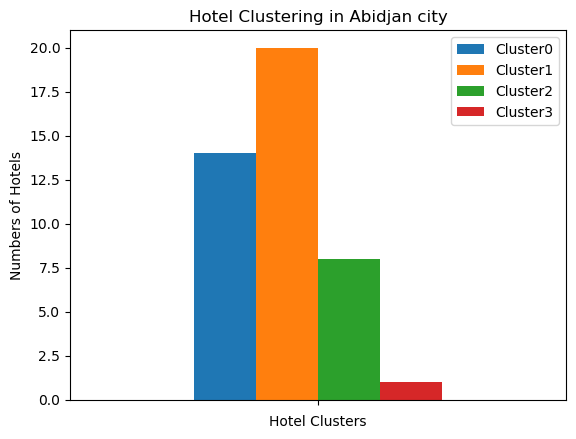

In [168]:
# create a bar plot of clusters to better visualize the number of hotels in each pf them

plt.style.use('default')  #choose the plot style


df_cl.plot(kind='bar')
plt.xlabel('Hotel Clusters')
plt.ylabel('Numbers of Hotels')
plt.title('Hotel Clustering in Abidjan city')



plt.show()

### There are fewer hotels in the ares around clusters 0, 2 and 3. Those areas from the map above coorespond to the districts of Marcory, Koumassi, Port Bouet and Ile Boulay. Let's dig  a bit in those areas. For this reason, we are going to create a barplot of representing the number of hotels in each district.

In [44]:
# let's group by districts to appreciate the number of hotels in each district

df_hotN = df_hot.groupby(['Districts']).count()
df_hotN

,Districts Latitude,Districts Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
Districts,,,,,,,
Adjame,3,3,3,3,3,3,3
Attecoube,3,3,3,3,3,3,3
Cocody,3,3,3,3,3,3,3
Ile Boulay,1,1,1,1,1,1,1
Koumassi,5,5,5,5,5,5,5
Marcory,12,12,12,12,12,12,12
Plateau,5,5,5,5,5,5,5
Port-Bouet,1,1,1,1,1,1,1
Treichville,10,10,10,10,10,10,10


In [46]:
# reset the index of the df_hotN dataframe
df_hotN.reset_index()

,Districts,Districts Latitude,Districts Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,Adjame,3,3,3,3,3,3,3
1,Attecoube,3,3,3,3,3,3,3
2,Cocody,3,3,3,3,3,3,3
3,Ile Boulay,1,1,1,1,1,1,1
4,Koumassi,5,5,5,5,5,5,5
5,Marcory,12,12,12,12,12,12,12
6,Plateau,5,5,5,5,5,5,5
7,Port-Bouet,1,1,1,1,1,1,1
8,Treichville,10,10,10,10,10,10,10


In [169]:
# let's create a new dataframe to accommodate the number of hotels per district
df_dis = pd.DataFrame({'Adjame':3, 'Attecoube':3, 'Cocody ':3, 'Ile Boulay':1, 'Koumassi':5,'Marcory':12, 'Plateau':5, 'Port-Bouet':1, 'Treichville':10} , index=[''])
df_dis

,Adjame,Attecoube,Cocody,Ile Boulay,Koumassi,Marcory,Plateau,Port-Bouet,Treichville
,3,3,3,1,5,12,5,1,10


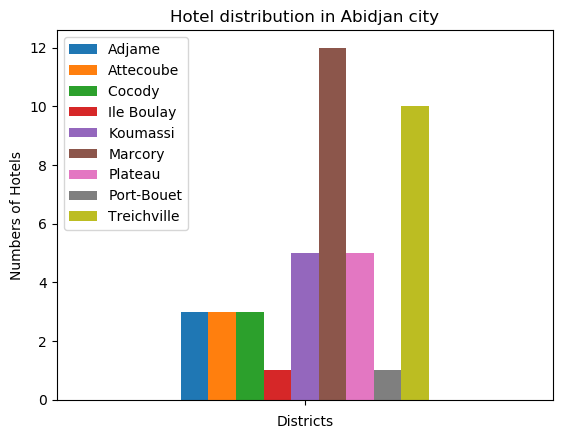

In [171]:
# create a bar plot of clusters to better visualize the number of hotels in each pf them

plt.style.use('default')  #choose the plot style


df_dis.plot(kind='bar')
plt.xlabel('Districts')
plt.ylabel('Numbers of Hotels')
plt.title('Hotel distribution in Abidjan city')



plt.show()

## Analysis and Discussion

When we surimpose the plots with the map of clusters, a few observations enable us to 
narrow down good prospects for the future 5-star hotel

1. **Cluster 0** that represent northern Abidjan has more hotels. Those areas consists of the districts of Cocody, Adjame, Plateau and Cocody. Unless Adjame, the other hotels listed are all at least  4-stars. Among these location, Plateau and Cocody have the highest number of 5-star hotels in Abidjan. We therefore, cancelled Cluster 0 is our list

2. Among the remaning cluster, meaning cluster 1, 2 and 3. The district of Treichville has 10 hotels alone with standing mostly being 3-stars hotels. An investigation of the standard of living of dwellers testifies that people belongs to middle-class. A 5-star hotel need more wealthy people

3. The list has therefore been narrowed down to 4 prospects: Marcory, Port-Bouet and Koumassi and Ile Boulay

4. Another screening considering social aspect such as the **average standard of living, the criminality, state of the road, accessibility of the area**, landscape helped **came up with only two prospects that are Port-Bouet and Ile Boulay**.

5. After discussing the ups and downs of the 2 areas, **Port-Bouet district, Bietry area was preferred to Ile Boulay**. 
Bietry is a luxury place with well off people coming from various countries. It is also an entertainment hub for 'VIPs'. A five-star Hotel will be a great success there. The criminality is very low in the area and the aforementioned criteria were all met.
Unlike Bietry which is in the city, Ile Boulay is an island. It is its advantage and disadvantage at the same time. The area is still underpopulated, and remained in rather under-developped state. The team concluded that for the time being small scale real estate projects might be the best options.

## Conclusion

•Data collected was considered very little. Therefore, more work needs to be carried out at the national level for a better cartography of the country. It helps potential investors in fields like real estate \

•The power of data science in elucidating a given problem was attempting \

•There is room for improving such as build a comprehensive and complex decision model including all possible influencing factors
